<a href="https://colab.research.google.com/github/duwi27sulis/Peramalan-LSTM_75-25/blob/main/Revnb_75_25_Update_H1_T6_Fix_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.0 MB/s eta 0:00:00


In [9]:
# Package
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import optuna
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [10]:
# Fix random seed for reproducibility
tf.random.set_seed(10)
plt.rcParams['figure.figsize'] = (12,6)

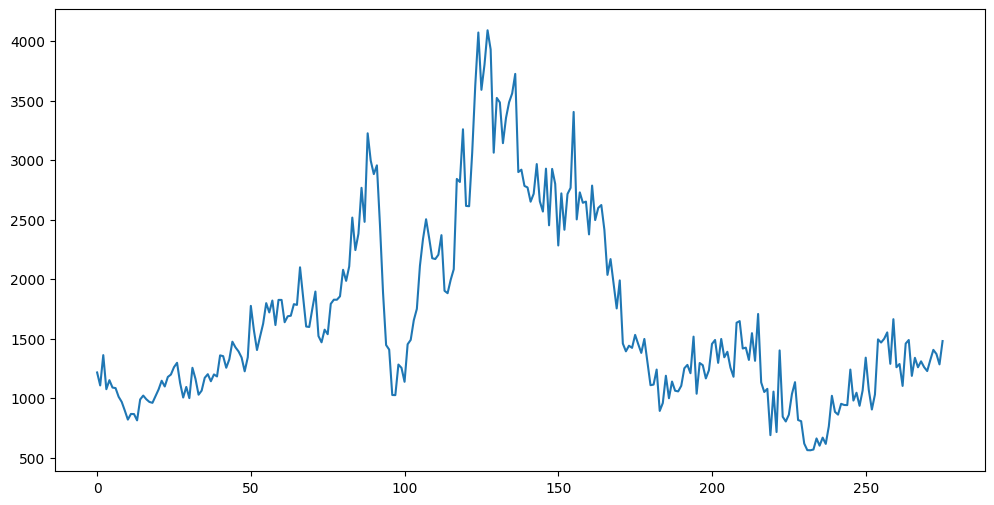

In [11]:
# Input Data
url = "https://raw.githubusercontent.com/duwi27sulis/Analisis_Data_LSTM/main/Ekspor-Migas-2001-2023.csv"
df = pd.read_csv(url, sep=",")
df['Tanggal'] = pd.to_datetime(df.Tanggal)
dataframe = pd.read_csv(url, usecols=[1], engine='python')
dataset = dataframe.values.astype('float32')
plt.plot(dataset)

In [12]:
# Pembagian data
#train_size = int(len(dataset)*0.75)
train_size = 207
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [13]:
time_steps = 6
last_row_train = train[-time_steps:]
test = np.concatenate([last_row_train, test], axis=0)

In [14]:
ytest = test
ytrain = train

In [15]:
# Normalisasi Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit(dataset)

train = scaled_data.transform(train)
test = scaled_data.transform(test)

In [16]:
# Fungsi untuk membuat dataset
def create_dataset (X, y, time_steps = time_steps):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

In [17]:
X_test, y_test = create_dataset(test, test)
X_train, y_train = create_dataset(train, train)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (201, 6, 1)
y_train.shape:  (201, 1)
X_test.shape:  (69, 6, 1)
y_test.shape:  (69, 1)


In [18]:
# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [19]:
# Define early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=20)

In [20]:
def objective(trial):
    # Define the search space
    lstm_units = trial.suggest_categorical('lstm_units', [32, 64, 128])
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.1, 0.2, 0.3, 0.4, 0.5])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = trial.suggest_int('epochs', 50, 200, 50)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])

    # Cross-validation scores
    cv_scores = []

    for fold_index, (train_index, val_index) in enumerate(tscv.split(X_train)):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Build the model
        model = Sequential([
            LSTM(units=lstm_units, input_shape=(X_train_fold.shape[1], 1)),
            Dropout(dropout_rate),
            Dense(1)
        ])

        # Select optimizer
        if optimizer_name == 'Adam':
            optimizer = Adam(learning_rate=learning_rate)
        elif optimizer_name == 'RMSprop':
            optimizer = RMSprop(learning_rate=learning_rate)
        else:
            optimizer = SGD(learning_rate=learning_rate)

        model.compile(optimizer=optimizer, loss='mse')

        # Fit the model
        history = model.fit(X_train_fold, y_train_fold,
                            validation_data=(X_val_fold, y_val_fold),
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[early_stopping],
                            verbose=0)

        # Evaluate the model
        val_pred = model.predict(X_val_fold)
        mse = mean_squared_error(y_val_fold, val_pred)
        cv_scores.append(mse)

        # Print MSE for each fold
        print(f"Fold {fold_index + 1}: MSE = {mse:.4f}")

    # Print average MSE across all folds
    print(f"Average MSE: {np.mean(cv_scores):.4f}")

    return np.mean(cv_scores)

In [21]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best parameters
print('Best parameters:', study.best_params)
print('Best value:', study.best_value)

[I 2024-08-13 08:49:36,694] A new study created in memory with name: no-name-74d341ce-b308-42fb-af45-9c78ca7badd8


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Fold 1: MSE = 0.0365
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 2: MSE = 0.0561


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 3: MSE = 0.1202
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
Fold 4: MSE = 0.0083
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-08-13 08:49:53,089] Trial 0 finished with value: 0.0457221195101738 and parameters: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.0457221195101738.


Fold 5: MSE = 0.0075
Average MSE: 0.0457
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 1: MSE = 0.0136
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
Fold 2: MSE = 0.0419
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Fold 3: MSE = 0.0160
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Fold 4: MSE = 0.0265
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[I 2024-08-13 08:50:13,183] Trial 1 finished with value: 0.020408589392900467 and parameters: {'lstm_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.020408589392900467.


Fold 5: MSE = 0.0041
Average MSE: 0.0204
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step
Fold 1: MSE = 0.0437
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 2: MSE = 0.1031
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Fold 3: MSE = 0.2135
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 4: MSE = 0.0357
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step


[I 2024-08-13 08:50:30,812] Trial 2 finished with value: 0.0826023742556572 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.020408589392900467.


Fold 5: MSE = 0.0169
Average MSE: 0.0826
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 1: MSE = 0.0294
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Fold 2: MSE = 0.0597
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
Fold 3: MSE = 0.0628
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 4: MSE = 0.0131
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-08-13 08:50:51,794] Trial 3 finished with value: 0.033354464918375015 and parameters: {'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.020408589392900467.


Fold 5: MSE = 0.0017
Average MSE: 0.0334
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
Fold 1: MSE = 0.0167
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 2: MSE = 0.0184
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 3: MSE = 0.0338
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Fold 4: MSE = 0.0331
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-08-13 08:51:14,543] Trial 4 finished with value: 0.02077675797045231 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.020408589392900467.


Fold 5: MSE = 0.0018
Average MSE: 0.0208
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 1: MSE = 0.0041
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 2: MSE = 0.0671
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Fold 3: MSE = 0.1258
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Fold 4: MSE = 0.0317
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-08-13 08:51:38,384] Trial 5 finished with value: 0.04764828830957413 and parameters: {'lstm_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.020408589392900467.


Fold 5: MSE = 0.0095
Average MSE: 0.0476
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step
Fold 1: MSE = 0.0643
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Fold 2: MSE = 0.0546
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step
Fold 3: MSE = 0.1191
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 4: MSE = 0.0352
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2024-08-13 08:51:54,830] Trial 6 finished with value: 0.06088756397366524 and parameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.020408589392900467.


Fold 5: MSE = 0.0313
Average MSE: 0.0609
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Fold 1: MSE = 0.0264
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Fold 2: MSE = 0.0345
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Fold 3: MSE = 0.1126
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Fold 4: MSE = 0.0104
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


[I 2024-08-13 08:52:13,296] Trial 7 finished with value: 0.03816591948270798 and parameters: {'lstm_units': 32, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.020408589392900467.


Fold 5: MSE = 0.0069
Average MSE: 0.0382
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Fold 1: MSE = 0.0302
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Fold 2: MSE = 0.0633
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 3: MSE = 0.0847
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step
Fold 4: MSE = 0.0100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


[I 2024-08-13 08:52:31,829] Trial 8 finished with value: 0.03799673914909363 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 200, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.020408589392900467.


Fold 5: MSE = 0.0018
Average MSE: 0.0380
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 1: MSE = 0.3739
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
Fold 2: MSE = 0.1250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 3: MSE = 0.0699
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 4: MSE = 0.0087
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


[I 2024-08-13 08:52:52,573] Trial 9 finished with value: 0.11603213846683502 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.020408589392900467.


Fold 5: MSE = 0.0027
Average MSE: 0.1160
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Fold 1: MSE = 0.0164
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Fold 2: MSE = 0.0416
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Fold 3: MSE = 0.0357
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 4: MSE = 0.0137
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


[I 2024-08-13 08:53:13,671] Trial 10 finished with value: 0.022060466930270195 and parameters: {'lstm_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.020408589392900467.


Fold 5: MSE = 0.0028
Average MSE: 0.0221
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
Fold 1: MSE = 0.0229
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Fold 2: MSE = 0.0247
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 3: MSE = 0.0200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Fold 4: MSE = 0.0350
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-08-13 08:53:35,036] Trial 11 finished with value: 0.020965421572327614 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.020408589392900467.


Fold 5: MSE = 0.0022
Average MSE: 0.0210
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Fold 1: MSE = 0.0227
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 2: MSE = 0.0161
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Fold 3: MSE = 0.0194
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Fold 4: MSE = 0.0167
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


[I 2024-08-13 08:53:54,894] Trial 12 finished with value: 0.015495195984840393 and parameters: {'lstm_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 12 with value: 0.015495195984840393.


Fold 5: MSE = 0.0025
Average MSE: 0.0155
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step
Fold 1: MSE = 0.0238
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Fold 2: MSE = 0.0222
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 3: MSE = 0.0186
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 4: MSE = 0.0234
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-08-13 08:54:17,923] Trial 13 finished with value: 0.01792718842625618 and parameters: {'lstm_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 12 with value: 0.015495195984840393.


Fold 5: MSE = 0.0015
Average MSE: 0.0179
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 1: MSE = 0.0168
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Fold 2: MSE = 0.0267
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Fold 3: MSE = 0.0244
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Fold 4: MSE = 0.0387
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-08-13 08:54:39,559] Trial 14 finished with value: 0.021664535626769066 and parameters: {'lstm_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 12 with value: 0.015495195984840393.


Fold 5: MSE = 0.0018
Average MSE: 0.0217
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Fold 1: MSE = 0.0251
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 339ms/step
Fold 2: MSE = 0.0267
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 3: MSE = 0.0113
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Fold 4: MSE = 0.0268
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


[I 2024-08-13 08:55:09,647] Trial 15 finished with value: 0.018305739387869835 and parameters: {'lstm_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 12 with value: 0.015495195984840393.


Fold 5: MSE = 0.0017
Average MSE: 0.0183
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 1: MSE = 0.0268
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Fold 2: MSE = 0.0217
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 3: MSE = 0.0291
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Fold 4: MSE = 0.0208
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-08-13 08:55:32,863] Trial 16 finished with value: 0.020231429487466812 and parameters: {'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 12 with value: 0.015495195984840393.


Fold 5: MSE = 0.0028
Average MSE: 0.0202
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Fold 1: MSE = 0.0251
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Fold 2: MSE = 0.0261
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 3: MSE = 0.0266
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 4: MSE = 0.0086
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step


[I 2024-08-13 08:55:55,887] Trial 17 finished with value: 0.017786718904972076 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 12 with value: 0.015495195984840393.


Fold 5: MSE = 0.0026
Average MSE: 0.0178
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 1: MSE = 0.0118
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 2: MSE = 0.0269
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
Fold 3: MSE = 0.0348
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Fold 4: MSE = 0.0155
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step


[I 2024-08-13 08:56:23,062] Trial 18 finished with value: 0.019028769806027412 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 12 with value: 0.015495195984840393.


Fold 5: MSE = 0.0061
Average MSE: 0.0190
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 1: MSE = 0.0189
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 2: MSE = 0.0365
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
Fold 3: MSE = 0.0382
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 4: MSE = 0.0074
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


[I 2024-08-13 08:56:46,916] Trial 19 finished with value: 0.020952392369508743 and parameters: {'lstm_units': 32, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 12 with value: 0.015495195984840393.


Fold 5: MSE = 0.0038
Average MSE: 0.0210
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Fold 1: MSE = 0.0198
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 2: MSE = 0.0266
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 3: MSE = 0.0281
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 4: MSE = 0.0081
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


[I 2024-08-13 08:57:11,516] Trial 20 finished with value: 0.01702597364783287 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 12 with value: 0.015495195984840393.


Fold 5: MSE = 0.0025
Average MSE: 0.0170
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step
Fold 1: MSE = 0.0148
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Fold 2: MSE = 0.0255
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Fold 3: MSE = 0.0257
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 4: MSE = 0.0080
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


[I 2024-08-13 08:57:37,473] Trial 21 finished with value: 0.015350138768553734 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 21 with value: 0.015350138768553734.


Fold 5: MSE = 0.0028
Average MSE: 0.0154
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
Fold 1: MSE = 0.0178
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Fold 2: MSE = 0.0227
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Fold 3: MSE = 0.0366
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Fold 4: MSE = 0.0084
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


[I 2024-08-13 08:58:04,781] Trial 22 finished with value: 0.0176667682826519 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 21 with value: 0.015350138768553734.


Fold 5: MSE = 0.0028
Average MSE: 0.0177
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step
Fold 1: MSE = 0.0164
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Fold 2: MSE = 0.0252
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Fold 3: MSE = 0.0287
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 4: MSE = 0.0087
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-08-13 08:58:28,720] Trial 23 finished with value: 0.01630672812461853 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 21 with value: 0.015350138768553734.


Fold 5: MSE = 0.0025
Average MSE: 0.0163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 1: MSE = 0.0180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Fold 2: MSE = 0.0259
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 3: MSE = 0.0318
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
Fold 4: MSE = 0.0097
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-08-13 08:58:52,761] Trial 24 finished with value: 0.01758342981338501 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 21 with value: 0.015350138768553734.


Fold 5: MSE = 0.0025
Average MSE: 0.0176
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 1: MSE = 0.0070
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Fold 2: MSE = 0.0228
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Fold 3: MSE = 0.0413
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Fold 4: MSE = 0.0080
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-08-13 08:59:13,176] Trial 25 finished with value: 0.016842659562826157 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 21 with value: 0.015350138768553734.


Fold 5: MSE = 0.0052
Average MSE: 0.0168
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Fold 1: MSE = 0.0155
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Fold 2: MSE = 0.0277
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Fold 3: MSE = 0.0274
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Fold 4: MSE = 0.0113
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step


[I 2024-08-13 08:59:42,872] Trial 26 finished with value: 0.0169452503323555 and parameters: {'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 21 with value: 0.015350138768553734.


Fold 5: MSE = 0.0028
Average MSE: 0.0169
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Fold 1: MSE = 0.0115
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
Fold 2: MSE = 0.0280
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Fold 3: MSE = 0.0285
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Fold 4: MSE = 0.0090
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


[I 2024-08-13 09:00:08,336] Trial 27 finished with value: 0.01596919633448124 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 21 with value: 0.015350138768553734.


Fold 5: MSE = 0.0029
Average MSE: 0.0160
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Fold 1: MSE = 0.0094
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 2: MSE = 0.0252
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 3: MSE = 0.0216
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 4: MSE = 0.0107
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


[I 2024-08-13 09:00:34,845] Trial 28 finished with value: 0.01386115700006485 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 28 with value: 0.01386115700006485.


Fold 5: MSE = 0.0024
Average MSE: 0.0139
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Fold 1: MSE = 0.0125
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 2: MSE = 0.0261
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 3: MSE = 0.0376
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Fold 4: MSE = 0.0177
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


[I 2024-08-13 09:00:57,800] Trial 29 finished with value: 0.01979772374033928 and parameters: {'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 28 with value: 0.01386115700006485.


Fold 5: MSE = 0.0052
Average MSE: 0.0198
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Fold 1: MSE = 0.0289
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 2: MSE = 0.0601
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 3: MSE = 0.0690
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 4: MSE = 0.0111
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-08-13 09:01:19,132] Trial 30 finished with value: 0.03416451811790466 and parameters: {'lstm_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 200, 'optimizer': 'SGD'}. Best is trial 28 with value: 0.01386115700006485.


Fold 5: MSE = 0.0017
Average MSE: 0.0342
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
Fold 1: MSE = 0.0108
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Fold 2: MSE = 0.0249
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 3: MSE = 0.0237
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Fold 4: MSE = 0.0092
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step


[I 2024-08-13 09:01:51,888] Trial 31 finished with value: 0.0141673032194376 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 28 with value: 0.01386115700006485.


Fold 5: MSE = 0.0023
Average MSE: 0.0142
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Fold 1: MSE = 0.0124
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
Fold 2: MSE = 0.0249
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 3: MSE = 0.0220
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 4: MSE = 0.0095
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


[I 2024-08-13 09:02:21,210] Trial 32 finished with value: 0.014324476011097431 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 28 with value: 0.01386115700006485.


Fold 5: MSE = 0.0028
Average MSE: 0.0143
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 1: MSE = 0.0127
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Fold 2: MSE = 0.0243
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 3: MSE = 0.0212
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Fold 4: MSE = 0.0084
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-08-13 09:02:51,102] Trial 33 finished with value: 0.013866198249161243 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 28 with value: 0.01386115700006485.


Fold 5: MSE = 0.0027
Average MSE: 0.0139
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
Fold 1: MSE = 0.0106
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 2: MSE = 0.0253
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Fold 3: MSE = 0.0248
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 4: MSE = 0.0114
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


[I 2024-08-13 09:03:18,179] Trial 34 finished with value: 0.014933345839381218 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 28 with value: 0.01386115700006485.


Fold 5: MSE = 0.0026
Average MSE: 0.0149
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step
Fold 1: MSE = 0.0098
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 2: MSE = 0.0251
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
Fold 3: MSE = 0.0239
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Fold 4: MSE = 0.0095
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-08-13 09:03:45,454] Trial 35 finished with value: 0.01413554884493351 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 28 with value: 0.01386115700006485.


Fold 5: MSE = 0.0023
Average MSE: 0.0141
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Fold 1: MSE = 0.0134
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step
Fold 2: MSE = 0.0242
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Fold 3: MSE = 0.0242
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Fold 4: MSE = 0.0102
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


[I 2024-08-13 09:04:17,198] Trial 36 finished with value: 0.014978431165218353 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 28 with value: 0.01386115700006485.


Fold 5: MSE = 0.0030
Average MSE: 0.0150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 1: MSE = 0.0088
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step
Fold 2: MSE = 0.0261
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 3: MSE = 0.0221
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 4: MSE = 0.0114
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-08-13 09:04:44,985] Trial 37 finished with value: 0.014173382893204689 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 28 with value: 0.01386115700006485.


Fold 5: MSE = 0.0025
Average MSE: 0.0142
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 1: MSE = 0.0840
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 2: MSE = 0.1899
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 3: MSE = 0.4814
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 4: MSE = 0.1917
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-08-13 09:05:03,015] Trial 38 finished with value: 0.19226989150047302 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 200, 'optimizer': 'SGD'}. Best is trial 28 with value: 0.01386115700006485.


Fold 5: MSE = 0.0143
Average MSE: 0.1923
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Fold 1: MSE = 0.0096
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 2: MSE = 0.0272
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
Fold 3: MSE = 0.0209
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Fold 4: MSE = 0.0099
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


[I 2024-08-13 09:05:30,094] Trial 39 finished with value: 0.014019203372299671 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 28 with value: 0.01386115700006485.


Fold 5: MSE = 0.0025
Average MSE: 0.0140
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 1: MSE = 0.3828
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 2: MSE = 0.2748
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
Fold 3: MSE = 0.3032
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Fold 4: MSE = 0.0098
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-08-13 09:05:54,898] Trial 40 finished with value: 0.19499261677265167 and parameters: {'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 28 with value: 0.01386115700006485.


Fold 5: MSE = 0.0045
Average MSE: 0.1950
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Fold 1: MSE = 0.0101
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 2: MSE = 0.0248
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 3: MSE = 0.0245
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Fold 4: MSE = 0.0091
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


[I 2024-08-13 09:06:21,578] Trial 41 finished with value: 0.014139963313937187 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 28 with value: 0.01386115700006485.


Fold 5: MSE = 0.0022
Average MSE: 0.0141
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 1: MSE = 0.0102
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 2: MSE = 0.0258
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
Fold 3: MSE = 0.0218
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Fold 4: MSE = 0.0104
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


[I 2024-08-13 09:06:53,885] Trial 42 finished with value: 0.014166097156703472 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 28 with value: 0.01386115700006485.


Fold 5: MSE = 0.0027
Average MSE: 0.0142
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Fold 1: MSE = 0.0086
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Fold 2: MSE = 0.0278
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Fold 3: MSE = 0.0184
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
Fold 4: MSE = 0.0095
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


[I 2024-08-13 09:07:21,537] Trial 43 finished with value: 0.013365985825657845 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 43 with value: 0.013365985825657845.


Fold 5: MSE = 0.0024
Average MSE: 0.0134
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 1: MSE = 0.0090
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 2: MSE = 0.0242
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 3: MSE = 0.0215
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step
Fold 4: MSE = 0.0089
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


[I 2024-08-13 09:07:48,680] Trial 44 finished with value: 0.013235688209533691 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 44 with value: 0.013235688209533691.


Fold 5: MSE = 0.0026
Average MSE: 0.0132
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 1: MSE = 0.0729
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step
Fold 2: MSE = 0.1665
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Fold 3: MSE = 0.4084
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Fold 4: MSE = 0.2014
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-08-13 09:08:05,573] Trial 45 finished with value: 0.17043447494506836 and parameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200, 'optimizer': 'SGD'}. Best is trial 44 with value: 0.013235688209533691.


Fold 5: MSE = 0.0031
Average MSE: 0.1704
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Fold 1: MSE = 0.0069
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Fold 2: MSE = 0.0498
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Fold 3: MSE = 0.0340
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Fold 4: MSE = 0.0324
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[I 2024-08-13 09:08:29,654] Trial 46 finished with value: 0.028749505057930946 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 44 with value: 0.013235688209533691.


Fold 5: MSE = 0.0206
Average MSE: 0.0287
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Fold 1: MSE = 0.0102
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 2: MSE = 0.0252
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step
Fold 3: MSE = 0.0241
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 4: MSE = 0.0097
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-08-13 09:08:57,763] Trial 47 finished with value: 0.014332237653434277 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 44 with value: 0.013235688209533691.


Fold 5: MSE = 0.0024
Average MSE: 0.0143
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Fold 1: MSE = 0.0091
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 2: MSE = 0.0263
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
Fold 3: MSE = 0.0226
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 4: MSE = 0.0086
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2024-08-13 09:09:24,507] Trial 48 finished with value: 0.013880809769034386 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 44 with value: 0.013235688209533691.


Fold 5: MSE = 0.0027
Average MSE: 0.0139
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 1: MSE = 0.0613
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Fold 2: MSE = 0.1509
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Fold 3: MSE = 0.3460
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 4: MSE = 0.1443
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-08-13 09:09:47,319] Trial 49 finished with value: 0.14094194769859314 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200, 'optimizer': 'SGD'}. Best is trial 44 with value: 0.013235688209533691.


Fold 5: MSE = 0.0022
Average MSE: 0.1409
Best parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}
Best value: 0.013235688209533691


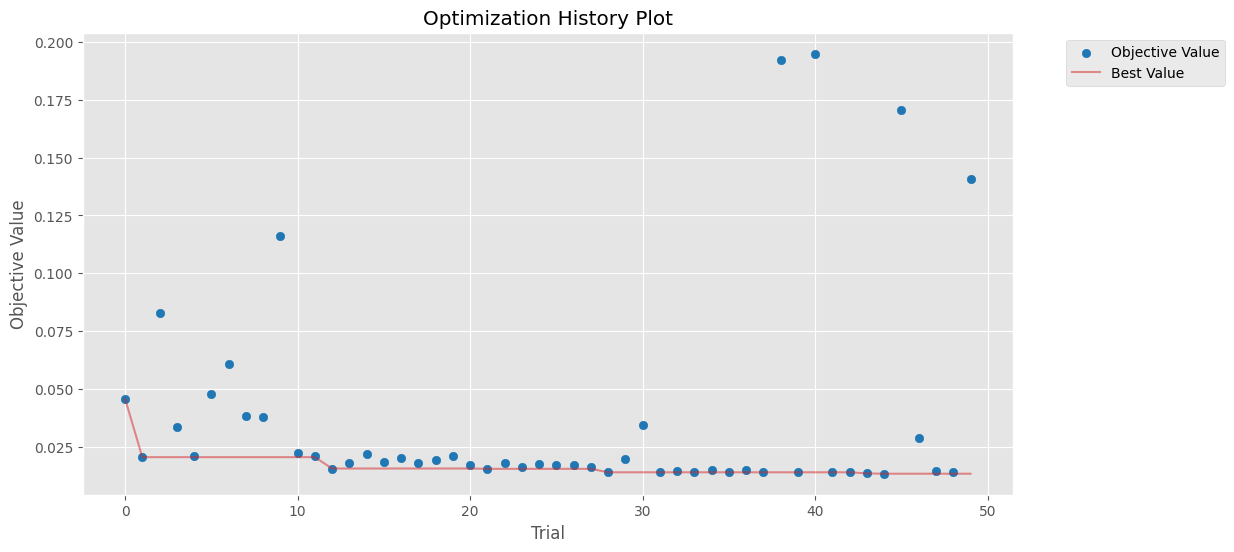

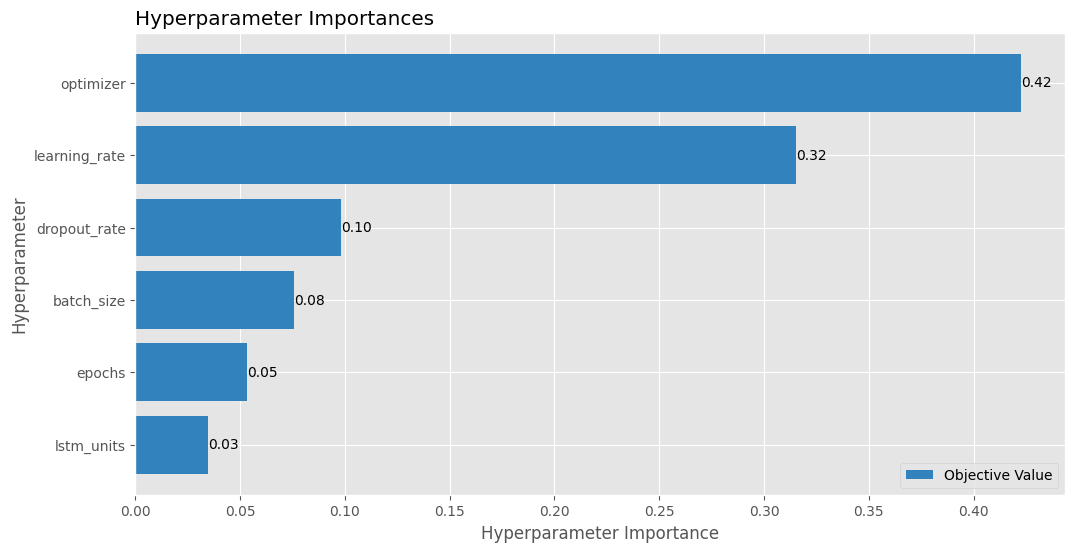

In [22]:
# Plot optimization history and parameter importances
plot_optimization_history(study)
plt.show()
plot_param_importances(study)
plt.show()

In [23]:
# Train final model with best parameters
best_params = study.best_params
model = Sequential([
    LSTM(units=best_params['lstm_units'], input_shape=(X_train.shape[1], 1)),
    Dropout(best_params['dropout_rate']),
    Dense(1)
])

# Select optimizer based on best parameters
if best_params['optimizer'] == 'Adam':
    optimizer = Adam(learning_rate=best_params['learning_rate'])
elif best_params['optimizer'] == 'RMSprop':
    optimizer = RMSprop(learning_rate=best_params['learning_rate'])
else:
    optimizer = SGD(learning_rate=best_params['learning_rate'])

model.compile(optimizer=optimizer, loss='mse')

# Train the model on the full training dataset
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=best_params['epochs'],
                    batch_size=best_params['batch_size'],
                    verbose=1)

Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.1826 - val_loss: 0.0102
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0563 - val_loss: 0.0073
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0180 - val_loss: 0.0363
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0327 - val_loss: 0.0176
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0160 - val_loss: 0.0054
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0151 - val_loss: 0.0034
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0156 - val_loss: 0.0049
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0125 - val_loss: 0.0084
Epoch 9/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0133 - val_loss: 0.0104
Epoch 10/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0137 - val_loss: 0.0079
Epoch 11/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0118 - val_loss: 0.0056
Epoch 12/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0105 - val_lo

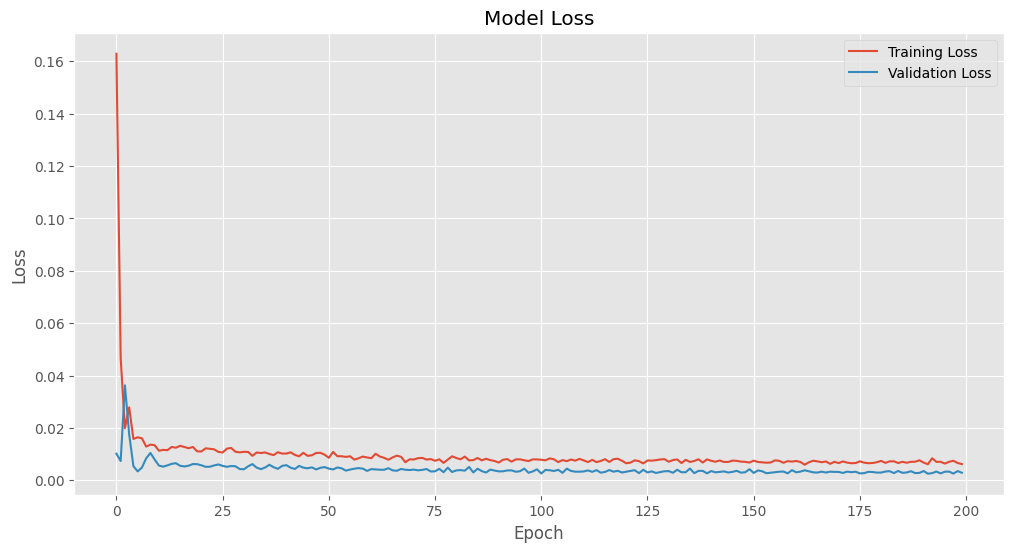

Average Loss: 0.0096


In [24]:
# Fungsi untuk plot training dan validation loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

plot_loss(history)

average_loss = np.mean(history.history['loss'])
print(f"Average Loss: {average_loss:.4f}")

In [25]:
# Make predictions on the training and testing datasets
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [26]:
# Inverse transform predictions and actual values
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

In [27]:
# Define a function to calculate MAE, MAPE, and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.mean(np.abs(errors / actual)) * 100  # Calculate MAPE

    print(model_name + ':')
    print('Mean Absolute Error: {:.3f}'.format(mae))
    print('Root Mean Square Error: {:.3f}'.format(rmse))
    print('Mean Absolute Percentage Error: {:.3f}%'.format(mape))
    print('')

In [28]:
# Evaluasi Model for Training Data
evaluate_prediction(train_predictions, y_train_actual, 'evaluasi model data train')

# Evaluasi Model for Testing Data
evaluate_prediction(test_predictions, y_test_actual, 'evaluasi model data test')

evaluasi model data train:
Mean Absolute Error: 184.848
Root Mean Square Error: 255.796
Mean Absolute Percentage Error: 10.028%

evaluasi model data test:
Mean Absolute Error: 170.333
Root Mean Square Error: 208.121
Mean Absolute Percentage Error: 16.349%



In [29]:
date_train = df['Tanggal'][time_steps:len(y_train_actual) + time_steps]
date_test = df['Tanggal'][-len(y_test_actual):]

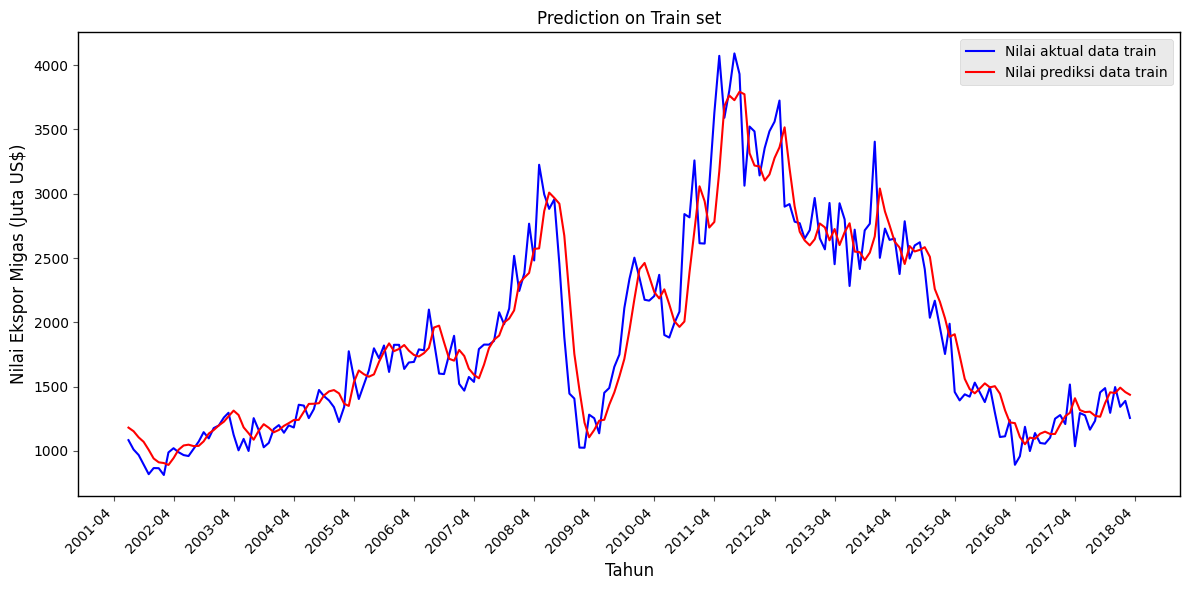

In [30]:
import matplotlib.dates as mdates
# Visualisasi prediksi vs aktual on train data
plt.figure(figsize=(12,6))
plt.title('Prediction on Train set', fontsize=12)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.plot(date_train, y_train_actual, label='Nilai aktual data train', color='blue')
plt.plot(date_train, train_predictions, label='Nilai prediksi data train', color='red')
plt.legend(fontsize=10)
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')

# Mengatur format tanggal
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

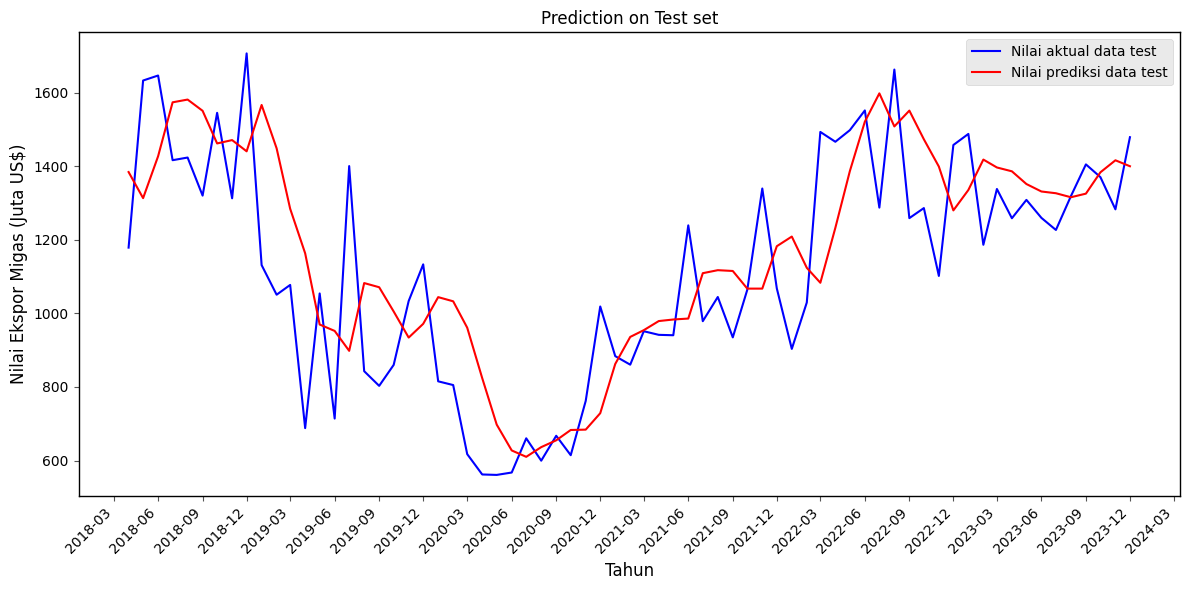

In [31]:
# Visualisasi prediksi vs aktual on test data
plt.figure(figsize=(12,6))
plt.title('Prediction on Test set', fontsize=12)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.plot(date_test, y_test_actual, label='Nilai aktual data test', color='blue')
plt.plot(date_test, test_predictions, label='Nilai prediksi data test', color='red')

# Mengatur format tanggal
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate dates for better visibility
plt.xticks(rotation=45)  # Memutar label x-axis agar lebih mudah dibaca
plt.legend(fontsize=10)
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

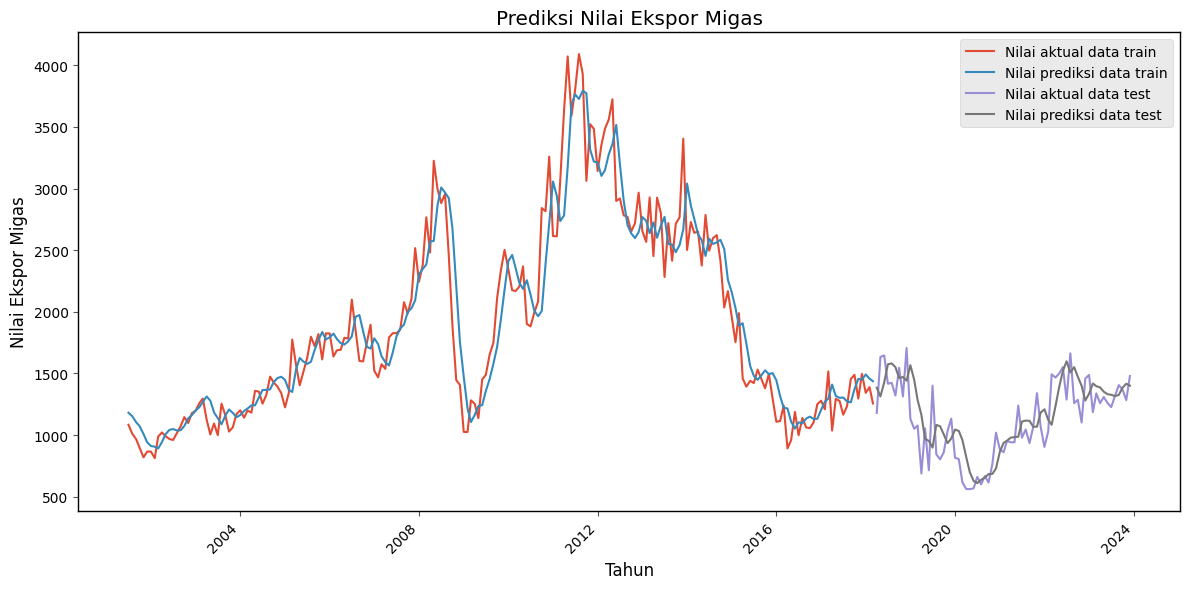

In [32]:
# Plot results
plt.figure(figsize=(12,6))
plt.plot(date_train, y_train_actual, label='Nilai aktual data train')
plt.plot(date_train, train_predictions, label='Nilai prediksi data train')
plt.plot(date_test, y_test_actual, label='Nilai aktual data test')
plt.plot(date_test, test_predictions, label='Nilai prediksi data test')
plt.title('Prediksi Nilai Ekspor Migas')
plt.xlabel('Tahun', color='black')
plt.ylabel('Nilai Ekspor Migas', color='black')
plt.legend(fontsize=10)
plt.legend()
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
      Tanggal  Nilai Ekspor Migas (Peramalan)
0  2024-01-01                     1445.989258
1  2024-02-01                     1474.671631
2  2024-03-01                     1505.927246
3  2024-04-01                     1540.255859
4  2024-05-01                     1571.101196
5  2024-06-01                     1594.247070
6  2024-07-01                     1625.867554
7  2024-08-01                     1654.040283
8  2024-09-01                     1681.660522
9  2024-10-01                     1708.887329
10 2024-11-01                     1735

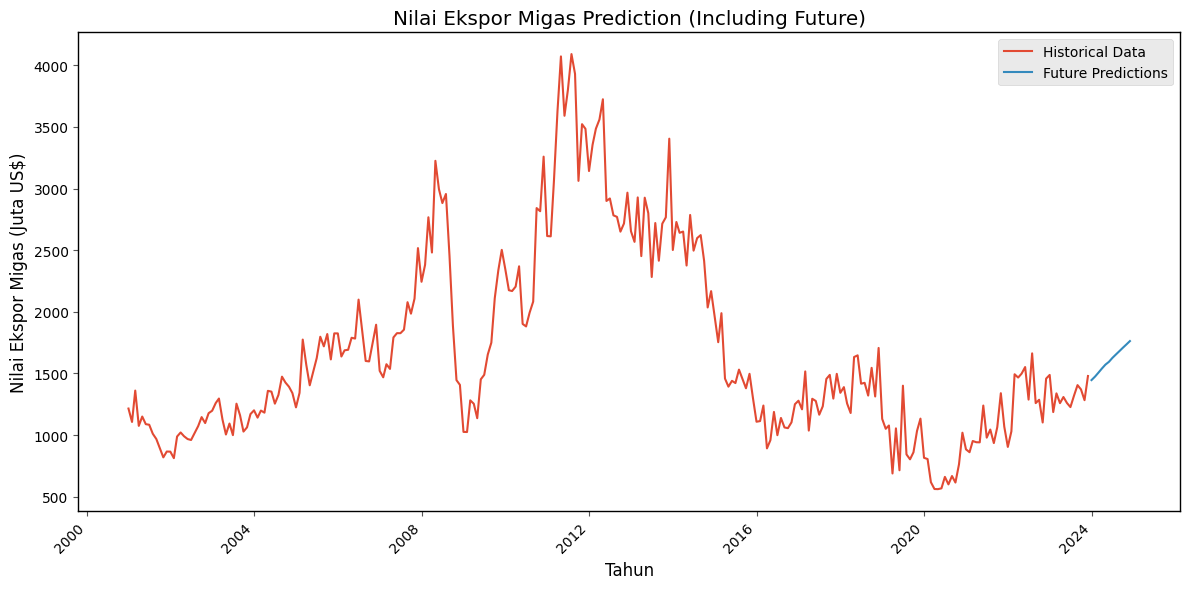

In [33]:
scaled_dt = scaler.fit_transform(dataset)

# Fungsi untuk melakukan peramalan
def forecast_future(model, last_data, periods, scaler):
    future_predictions = []
    current_batch = last_data

    for _ in range(periods):
        # Prediksi satu langkah ke depan
        current_pred = model.predict(current_batch)
        future_predictions.append(current_pred[0])

        # Update batch untuk prediksi berikutnya
        current_batch = np.roll(current_batch, -1, axis=1)
        current_batch[0, -1, 0] = current_pred[0]

    # Inverse transform hasil peramalan
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    return scaler.inverse_transform(future_predictions)

# Ambil data terakhir untuk input peramalan
last_known_data = scaled_dt[-time_steps:]
last_known_data = last_known_data.reshape((1, time_steps, 1))

# Lakukan peramalan untuk 12 periode ke depan
future_periods = 12
future_predictions = forecast_future(model, last_known_data, future_periods, scaler)

# Buat tanggal untuk hasil peramalan
last_date = df['Tanggal'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=30), periods=future_periods, freq='MS')

# Buat DataFrame untuk hasil peramalan
forecast_df = pd.DataFrame({
    'Tanggal': future_dates,
    'Nilai Ekspor Migas (Peramalan)': future_predictions.flatten()
})

print(forecast_df)

# Plot future predictions
plt.figure(figsize=(12,6))
plt.plot(df['Tanggal'], df['Nilai Ekspor Migas'], label='Historical Data')
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.title('Nilai Ekspor Migas Prediction (Including Future)')
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()


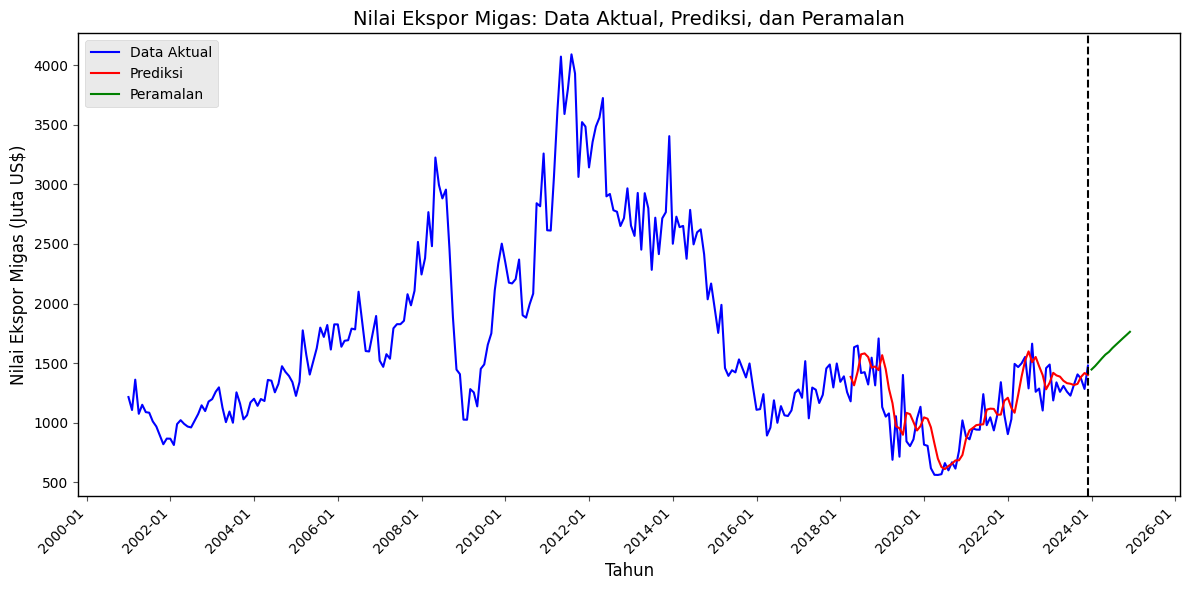

In [34]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Mengubah future_dates menjadi Series
future_dates_series = pd.Series(future_dates)

# Menggabungkan data aktual, prediksi data uji, dan hasil peramalan
all_dates = pd.concat([df['Tanggal'], future_dates_series])
all_actual = pd.concat([df['Nilai Ekspor Migas'], pd.Series([np.nan] * len(future_dates))])
all_predictions = np.concatenate([np.array([np.nan] * (len(df) - len(test_predictions))),
                                  test_predictions.flatten(),
                                  future_predictions.flatten()])

# Membuat plot
plt.figure(figsize=(12, 6))
plt.plot(all_dates, all_actual, label='Data Aktual', color='blue')

# Garis prediksi
plt.plot(all_dates[-len(test_predictions)-len(future_predictions):-len(future_predictions)],
         all_predictions[-len(test_predictions)-len(future_predictions):-len(future_predictions)],
         label='Prediksi', color='red')

# Garis peramalan
plt.plot(all_dates[-len(future_predictions):],
         all_predictions[-len(future_predictions):],
         label='Peramalan', color='green')

# Menambahkan garis vertikal untuk memisahkan data uji dan peramalan
split_date = df['Tanggal'].iloc[-1]
plt.axvline(x=split_date, color='black', linestyle='--')

plt.title('Nilai Ekspor Migas: Data Aktual, Prediksi, dan Peramalan', fontsize=14)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')

# Mengatur format tanggal pada sumbu x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=2))

plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

In [35]:
!pip install openpyxl

In [36]:
forecast_df.to_excel('forecast_75:25_h1t6.xlsx', index=False)
from google.colab import files
files.download('forecast_75:25_h1t6.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
import numpy as np
import pandas as pd

# Konversi y_train_actual, train_predictions, y_test_actual, dan test_predictions ke array satu dimensi
y_train_actual = np.array(y_train_actual).flatten()
train_predictions = np.array(train_predictions).flatten()
y_test_actual = np.array(y_test_actual).flatten()
test_predictions = np.array(test_predictions).flatten()

# Buat DataFrame untuk nilai aktual dan prediksi data train
# Membuat DataFrame hasil untuk training dan testing
train_df = pd.DataFrame({
    'Tanggal': date_train.reset_index(drop=True),
    'Data Aktual': y_train_actual,
    'Data Prediksi': train_predictions
})

# Buat DataFrame untuk nilai aktual dan prediksi data test
test_df = pd.DataFrame({
    'Tanggal': date_test.reset_index(drop=True),
    'Data Aktual': y_test_actual,
    'Data Prediksi': test_predictions
})

# Gabungkan train_df dan test_df menjadi satu DataFrame
prediksi_df = pd.concat([train_df, test_df])

# Simpan DataFrame ke dalam file Excel
prediksi_df.to_excel('prediksi_75:25_h1t6.xlsx', index=False)

# Jika Anda menggunakan Google Colab, Anda dapat mengunduh file Excel
from google.colab import files
files.download('prediksi_75:25_h1t6.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>